# Preparação do ambiente

## Bibliotecas

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import unidecode
import warnings 

from joblib import dump, load

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from string import punctuation

from tabulate import tabulate

from wordcloud import WordCloud

In [2]:
# Settings the warnings to be ignored 
warnings.filterwarnings('ignore')

## Constantes e funções auxiliares

In [3]:
FILE_ITEMS = '../datasets/label_issues/20240423/results/items.parquet'

In [5]:
def tokenizer(doc):
    doc = doc.lower()
    doc = unidecode.unidecode(doc)
    
    # uniformizar termos
    patterns = [('wi\s?.?fi', 'wifi'), 
                ('2,4', '2.4'), 
                ('5,8', '5.8')]
    for pattern, repl in patterns:
        doc = re.sub(pattern, repl, doc)
    
    stop_words = stopwords.words('portuguese')
    stop_words.extend(stopwords.words('english'))
    stop_words.extend(list(punctuation))
    
    # stopwords específicas do domínio
    stop_words.extend(['cm', 'feature', 'features', 'informações', 'itens', 'leve', 'list', 'nulo', 'package', 'pacote', 'pacotes', 'recurso', 'tamanho', 'ver', 'unidades', 'fio', 'universal'])
    
    # cores mais comumns
    stop_words.extend(['preto', 'cinza', 'branco', 'rosa', 'vermelho', 'laranja', 'amarelo', 'verde', 'azul', 'roxo', 'marrom'])
    
    # remover da lista de stopwords a palavra sem para formar o bigrama "sem fio", que pode ser relevante para o domínio
    # stop_words.remove('sem') 
    
    tokens = [token for token in word_tokenize(doc) if token not in stop_words]
    return tokens

def doc_cleaner(doc):
    tokens = tokenizer(doc)
    return ' '.join(tokens) 

In [38]:
def plot_docs_matrix(docs_matrix, true_targets=None, predicted_targets=None, title=None):
    pca = TruncatedSVD(n_components=2)
    pca_matrix = pca.fit_transform(docs_matrix)
    scatter_x = pca_matrix[:, 0] # first principle component
    scatter_y = pca_matrix[:, 1] # second principle component
    
    if predicted_targets is None:
        fig,ax = plt.subplots(figsize=(6,5))
        if true_targets is not None:
            for group in np.unique(true_targets):
                ix = np.where(true_targets == group)
                ax.scatter(scatter_x[ix], scatter_y[ix], label=group, s=5)
                if title is None:
                    ax.set_title('Anúncios por grupo\n(Real)')   
                else:
                    ax.set_title(title)
        else:
            ax.scatter(scatter_x, scatter_y, s=5)
            if title is None:
                ax.set_title('Anúncios')
            else:
                ax.set_title(title)
        ax.set_xticks([])
        ax.set_yticks([])
        
    else:
        fig,axs = plt.subplots(1,2,figsize=(12,5))
        if true_targets is not None:
            for group in np.unique(true_targets):
                ix = np.where(true_targets == group)
                axs[0].scatter(scatter_x[ix], scatter_y[ix], label=group, s=5)
                if title is None:
                    axs[0].set_title('Anúncios por grupo\n(Real)')   
                else:
                    axs[0].set_title(title)
        else:
            axs[0].scatter(scatter_x, scatter_y, s=5)
            if title is None:
                axs[0].set_title('Anúncios')
            else:
                axs[0].set_title(title)
        
        for group in np.unique(predicted_targets):
            ix = np.where(predicted_targets == group)
            axs[1].scatter(scatter_x[ix], scatter_y[ix], label=group, s=5)
            axs[1].set_title('Anúncios por grupo\n(K-Means)')

        for ax in axs.flat:
            ax.set_xticks([])
            ax.set_yticks([])
        
    plt.show()

# Carga e prepação dos dados

In [14]:
df_items = pd.read_parquet(FILE_ITEMS)

map_groups = {(0,0):0, (1,0):1, (1,1):2}
df_items['grupo'] = df_items.apply(lambda row: (row['passivel_homologacao'],row['transmissor_rf']),axis=1).map(map_groups).fillna(3).astype(int)

df_items

,id,nome,desc,titulo_bem_elaborado,titulo_identifica_produto,desc_bem_elaborada,desc_identifica_produto,passivel_homologacao,transmissor_rf,tipo_produto,grupo
0,125728,Streaming Box S Tucson 2018 A 2022 Carplay 4g ...,STREAMING BOX S - 2GB RAM | 32GB ARMAZENAMENTO...,1,1,1,1,1,1,TV Box/TV Stick,2
1,125729,Smartphone Motorola Moto G52 XT2221-1 Dual Sim...,Fotografia profissional no seu bolsoDescubra i...,1,1,1,1,1,1,Smartphones,2
2,125730,Notebook Dell Latitude 7490 I5 8ª Ger Ddr4 16g...,Os produtos da Dell destacam-se por oferecer s...,1,1,1,1,1,1,Computador ou notebook,2
3,125731,"Mini rede sem fio, placa de rede sem fio USB 3...",,1,1,2,2,1,1,Transceptor de radiação restrita (2.4GHz/5.8GHz),2
4,125732,"Fone Bluetooth TWS Kaidi KD-771 - 5.1, Touch, ...","Fone Bluetooth Tws, Kaidi Kd-771, Bluetooth 5....",1,1,1,1,1,1,Transceptor de radiação restrita (2.4GHz/5.8GHz),2
...,...,...,...,...,...,...,...,...,...,...,...
18831,125715,CAIXA ACUSTICA PCX6500,,0,1,2,2,1,1,Transceptor de radiação restrita (2.4GHz/5.8GHz),2
18832,125716,Conector de cauda de celular 10 pcs carregando...,"[De alta qualidade] 100% nova fábrica, segura...",1,1,1,1,0,0,Outro tipo/categoria (não listada acima),0
18833,125717,Avantree Medley Clear - Fones de ouvido sem fi...,,1,1,2,2,1,1,Transceptor de radiação restrita (2.4GHz/5.8GHz),2
18834,125718,"Hilitand Adaptador sem fio, placa de rede sem ...",,1,1,2,2,1,1,Transceptor de radiação restrita (2.4GHz/5.8GHz),2


# Análise

## Análise exploratória

In [43]:
df_tipo_produto = df_items[['tipo_produto','id']].groupby('tipo_produto').count()
df_tipo_produto = df_tipo_produto.sort_values(by='id',ascending=False)
df_tipo_produto.columns = ['Quantidade']
df_tipo_produto.index.name = 'Tipo de produto'
df_tipo_produto

,Quantidade
Tipo de produto,
Outro tipo/categoria (não listada acima),8242
Transceptor de radiação restrita (2.4GHz/5.8GHz),3529
Não é possível afirmar,1503
Carregador para celular (inclusive powerbank),1359
Smartphones,1177
Drone,758
Transceptor de radiofrequência (VHF/UHF),464
Roteador/repetidor/reforçador WiFi (2.4GHz/5.8GHz),458
Bateria de lítio para celular,439


In [15]:
map_titulo = {0: 'Não', 1: 'Sim'}
df_titulo = df_items.pivot_table(index='titulo_bem_elaborado',columns='titulo_identifica_produto',values='id',aggfunc='count')
df_titulo.columns = df_titulo.columns.map(map_titulo)
df_titulo.columns.name = 'Título identifica o produto?'
df_titulo.index = df_titulo.index.map(map_titulo)
df_titulo.index.name = 'Título bem elaborado?'
df_titulo['Total'] = df_titulo.sum(axis=1)
df_titulo.loc['Total'] = df_titulo.sum(axis=0)

df = df_titulo.style.format(precision=3, thousands=".", decimal=",")
display(df)

Título identifica o produto?,Não,Sim,Total
Título bem elaborado?,,,
Não,1.662,5.064,6.726
Sim,304,11.806,12.110
Total,1.966,16.870,18.836


In [16]:
map_desc = {0: 'Não', 1: 'Sim', 2: 'Anúncio não possui descrição'}
df_desc = df_items.pivot_table(index='desc_bem_elaborada',columns='desc_identifica_produto',values='id',aggfunc='count')
df_desc.columns = df_desc.columns.map(map_desc)
df_desc.columns.name = 'Descrição identifica o produto?'
df_desc.index = df_desc.index.map(map_desc)
df_desc.index.name = 'Descrição bem elaborada?'
df_desc['Total'] = df_desc.sum(axis=1)
df_desc.loc['Total'] = df_desc.sum(axis=0)

df = df_desc.style.format(precision=3, thousands=".", decimal=",")
display(df)

Descrição identifica o produto?,Não,Sim,Anúncio não possui descrição,Total
Descrição bem elaborada?,,,,
Não,915,1.498,6,2.419
Sim,228,6.972,8,7.208
Anúncio não possui descrição,6,21,9.182,9.209
Total,1.149,8.491,9.196,18.836


In [17]:
map_passivel = {0: 'Não', 1: 'Sim', 2: 'Não é possível afirmar'}
df_passivel = df_items.pivot_table(index='passivel_homologacao',columns='transmissor_rf',values='id',aggfunc='count')
df_passivel = df_passivel.fillna(0).astype(int)
df_passivel.columns = df_passivel.columns.map(map_passivel)
df_passivel.columns.name = 'Produto transmissor de RF?'
df_passivel.index = df_passivel.index.map(map_passivel)
df_passivel.index.name = 'Produto passível de homologação?'
df_passivel['Total'] = df_passivel.sum(axis=1)
df_passivel.loc['Total'] = df_passivel.sum(axis=0)

df = df_passivel.style.format(precision=3, thousands=".", decimal=",")
display(df)

Produto transmissor de RF?,Não,Sim,Não é possível afirmar,Total
Produto passível de homologação?,,,,
Não,7.471,0,2,7.473
Sim,1.978,7.888,53,9.919
Não é possível afirmar,68,2,1.374,1.444
Total,9.517,7.890,1.429,18.836


In [18]:
df_passivel = df_items[(df_items['passivel_homologacao']<2)&(df_items['transmissor_rf']<2)].pivot_table(index='passivel_homologacao',columns='transmissor_rf',values='id',aggfunc='count')
df_passivel = df_passivel.fillna(0).astype(int)
df_passivel.columns = df_passivel.columns.map(map_passivel)
df_passivel.columns.name = 'Produto transmissor de RF?'
df_passivel.index = df_passivel.index.map(map_passivel)
df_passivel.index.name = 'Produto passível de homologação?'
df_passivel['Total'] = df_passivel.sum(axis=1)
df_passivel.loc['Total'] = df_passivel.sum(axis=0)

df = df_passivel.style.format(precision=3, thousands=".", decimal=",")
display(df)

Produto transmissor de RF?,Não,Sim,Total
Produto passível de homologação?,,,
Não,7.471,0,7.471
Sim,1.978,7.888,9.866
Total,9.449,7.888,17.337


## Espaço vetorial

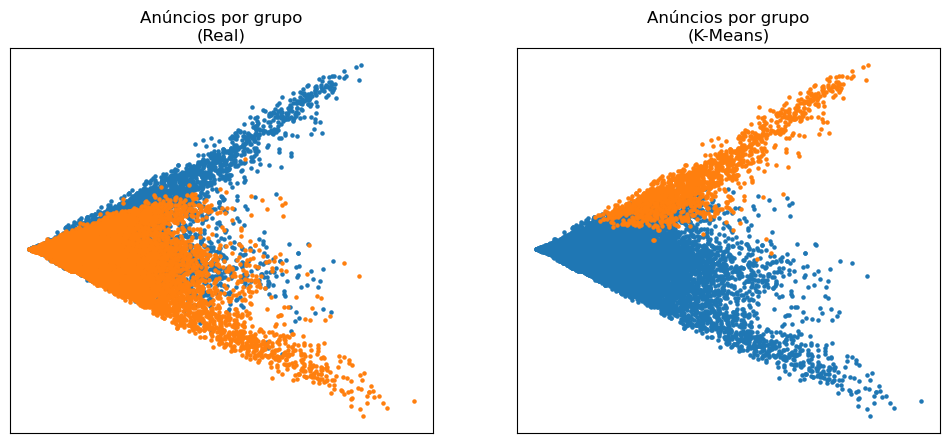

In [55]:
columns_to_keep = ['nome','passivel_homologacao']
df_docs = df_items[df_items['passivel_homologacao']<2][columns_to_keep]

docs_passivel = df_docs['nome'].values
targets_passivel = df_docs['passivel_homologacao'].values

vectorizer = TfidfVectorizer(tokenizer=tokenizer)
docs_matrix_passivel = vectorizer.fit_transform(docs_passivel)

kmeans_passivel = KMeans(n_clusters=2, max_iter=500, n_init=3).fit(docs_matrix_passivel)
predicted_targets_passivel = kmeans_passivel.labels_

plot_docs_matrix(docs_matrix_passivel,true_targets=targets_passivel,predicted_targets=predicted_targets_passivel)

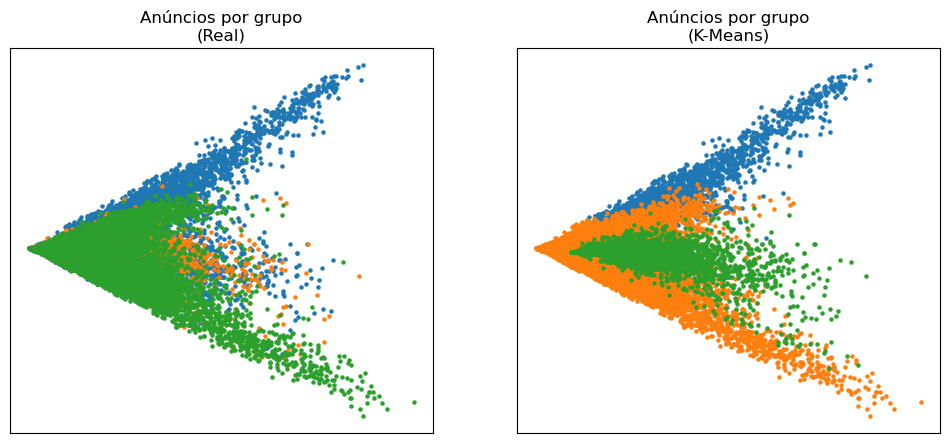

In [56]:
columns_to_keep = ['nome','grupo']
df_docs_grupo = df_items[df_items['grupo']<3][columns_to_keep]

docs_grupo = df_docs_grupo['nome'].values
targets_grupo = df_docs_grupo['grupo'].values

vectorizer = TfidfVectorizer(tokenizer=tokenizer)
docs_matrix_grupo = vectorizer.fit_transform(docs_grupo)

kmeans_grupo = KMeans(n_clusters=3, max_iter=500, n_init=3).fit(docs_matrix_grupo)
predicted_targets_grupo = kmeans_nome.labels_

plot_docs_matrix(docs_matrix,true_targets=targets_grupo,predicted_targets=predicted_targets_grupo)

## Principais palavras

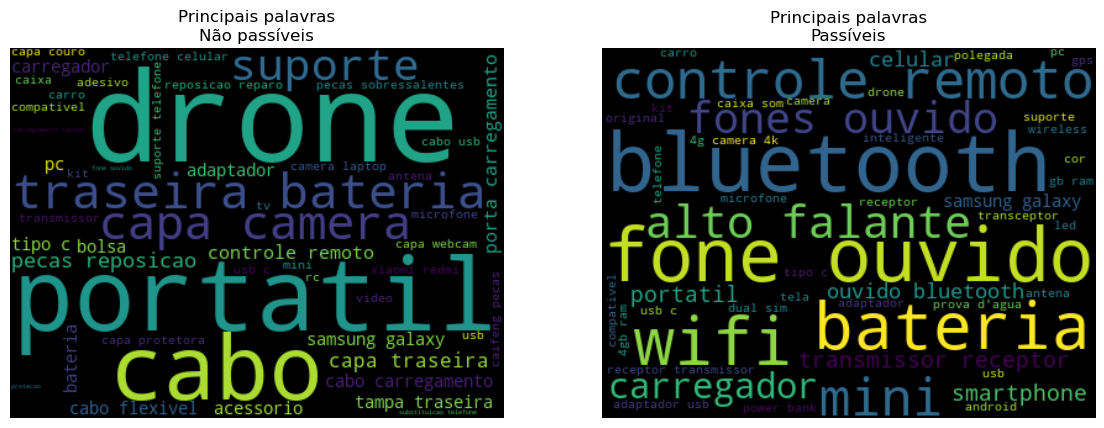

In [57]:
map_passivel = {
    0: 'Não passíveis', 
    1: 'Passíveis'}

fig, axs = plt.subplots(1,2,figsize=(14,5))

targets = [0,1]
for target in targets:
    docs = df_items[df_items['passivel_homologacao']==target]['nome']
    docs = [doc_cleaner(doc) for doc in docs]
    title = f'Principais palavras\n{map_passivel[target]}'
    plot_wordcloud(docs,ax=axs[target],title=title)

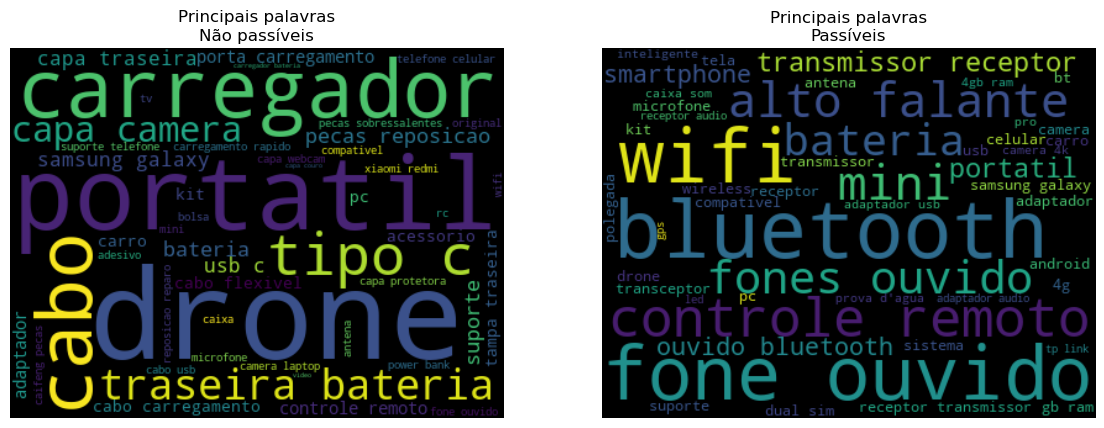

In [59]:
map_transmissor_rf = {
    0: 'Não transmissor', 
    1: 'Transmissor de RF'}

fig, axs = plt.subplots(1,2,figsize=(14,5))

targets = [0,1]
for target in targets:
    docs = df_items[df_items['transmissor_rf']==target]['nome']
    docs = [doc_cleaner(doc) for doc in docs]
    title = f'Principais palavras\n{map_passivel[target]}'
    plot_wordcloud(docs,ax=axs[target],title=title)

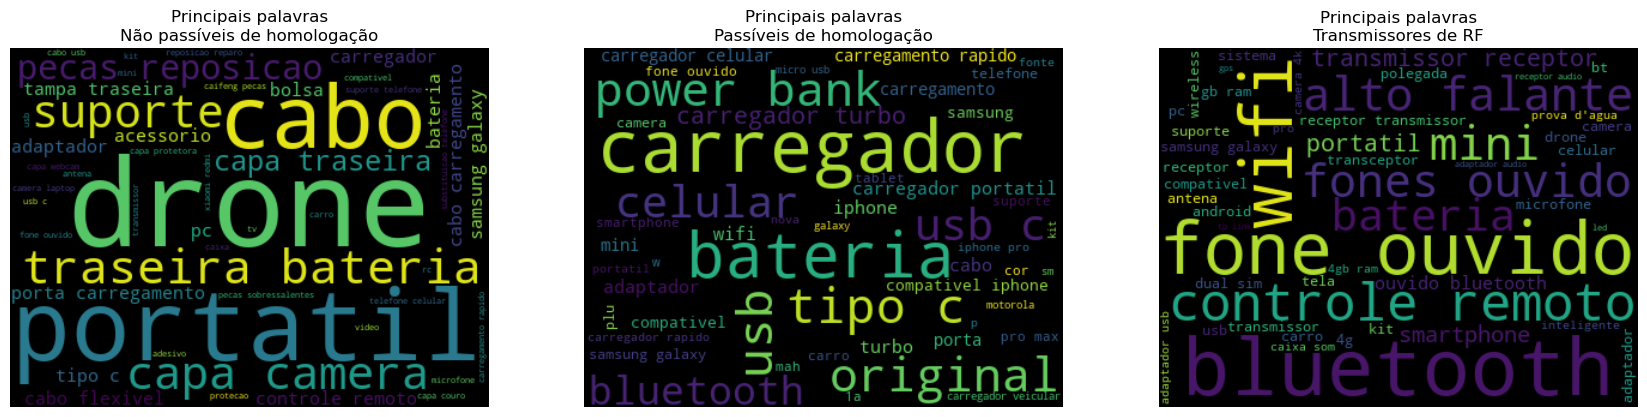

In [58]:
map_group = {
    0: 'Não passíveis de homologação', 
    1: 'Passíveis de homologação', 
    2: 'Transmissores de RF'}

fig, axs = plt.subplots(1,3,figsize=(21,5))

targets = [0,1,2]
for target in targets:
    docs = df_items[df_items['grupo']==target]['nome']
    docs = [doc_cleaner(doc) for doc in docs]
    title = f'Principais palavras\n{map_groups[target]}'
    plot_wordcloud(docs,ax=axs[target],title=title)

## Classificador SGD

In [64]:
df_items.columns

Index(['id', 'nome', 'desc', 'titulo_bem_elaborado',
       'titulo_identifica_produto', 'desc_bem_elaborada',
       'desc_identifica_produto', 'passivel_homologacao', 'transmissor_rf',
       'tipo_produto', 'grupo'],
      dtype='object')

Accuracy of SGD classifier on training set: 0.883
Accuracy of SGD classifier on test set: 0.871
AUC of SGD classifier on test set: 0.944

               precision    recall  f1-score   support

Não passíveis       0.94      0.75      0.83      1870
    Passíveis       0.84      0.96      0.89      2478

     accuracy                           0.87      4348
    macro avg       0.89      0.86      0.86      4348
 weighted avg       0.88      0.87      0.87      4348



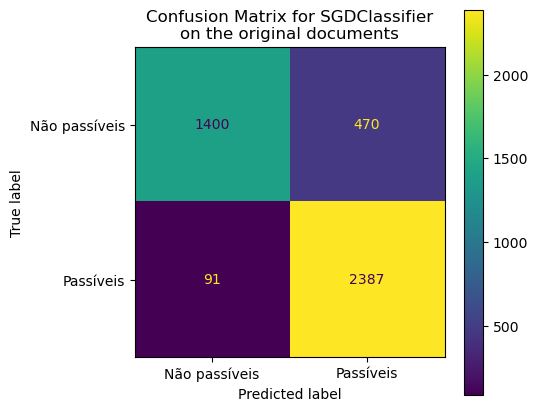

In [66]:
X = df_items[df_items['passivel_homologacao']<2]['nome'].values
y = df_items[df_items['passivel_homologacao']<2]['passivel_homologacao']

target_names = list(map_passivel.values())
target_names_confusion = list(map_passivel.values())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=724)

tfidf_vectorizer = TfidfVectorizer(tokenizer=tokenizer)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

clf_sgd_telecom = SGDClassifier(loss='log_loss', penalty='l2',
                                alpha=1e-3, random_state=42,
                                max_iter=5, tol=None)

clf_sgd_telecom.fit(X_train_tfidf, y_train)

# persist model
# dump(clf_sgd_telecom, '../models/clf_sgd_telecom.joblib') 

predicted = clf_sgd_telecom.predict(X_test_tfidf)
print('Accuracy of SGD classifier on training set: {:.3f}'
     .format(clf_sgd_telecom.score(X_train_tfidf, y_train)))
print('Accuracy of SGD classifier on test set: {:.3f}'
     .format(clf_sgd_telecom.score(X_test_tfidf, y_test)))
print('AUC of SGD classifier on test set: {:.3f}'
     .format(roc_auc_score(y_test,clf_sgd_telecom.predict_proba(X_test_tfidf)[:,1])))

print()
print(classification_report(y_test, predicted, target_names=target_names))

fig, ax = plt.subplots(figsize=(5, 5))
ConfusionMatrixDisplay.from_predictions(y_test, predicted, ax=ax)
ax.xaxis.set_ticklabels(target_names_confusion)
ax.yaxis.set_ticklabels(target_names_confusion)
_ = ax.set_title(f"Confusion Matrix for {clf_sgd_telecom.__class__.__name__}\non the original documents")